In [53]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
print(np.__version__)

1.16.5


In [80]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

def number_density_sphere_pc( Mass_sol, Radius_pc, mu ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the number density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    n = Mass / (((4. / 3.)*np.pi) * mu * mh * Radius**3.0)

    # Convert to particles per cubic centimetre

    n = n / percm2perm

    return n

def mass_density_sphere( Mass_sol, Radius_pc ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the mass density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    rho = Mass / (((4. / 3.)*np.pi) * Radius**3.0)

    return rho

def tff_spherical( number_density, mu ):

    # Accepts a number density in units of particles per cubic centimetre and derives the free fall time in yrs

    mass_density = mu * mh * number_density * percm2perm

    tff = np.sqrt( (3. * np.pi) / (32. * G * mass_density) )

    tff = tff / sin1yr # free-fall time in years

    return tff

def Mbc(Nbc,sigma):  ### calculate critical binding mass for given column density and dispersion, via phil myers
    return 2.32e25*(sigma**4)/Nbc

In [79]:
catalog.keys()

['index',
 'area_ellipse',
 'area_exact',
 'flux_integrated',
 'major_sigma',
 'minor_sigma',
 'position_angle',
 'radius',
 'glon',
 'glat',
 'r_eff',
 'testflux_integrated',
 'flux_integrated_bgsub',
 'min_flux_integrated',
 'noise',
 'is_leaf',
 'peak_cont_flux',
 'min_cont_flux',
 'mean_cont_flux',
 'npix',
 'ColumnDensity',
 'mass',
 'N',
 'r_eff_pc',
 'Sigma',
 'n',
 'rho',
 'tff',
 'glon_0',
 'mass_bgsub']

In [20]:
################################################
### load tables and data
################################################
path = '/Users/hph/cmzoom_catalog/catalog_acc/'

catalog = Table.read(path+'catalog_acc.fits')
Herschel_N = catalog['ColumnDensity']
SMA_mass = catalog['mass']
noise_JySr = catalog['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * catalog['area_exact']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)


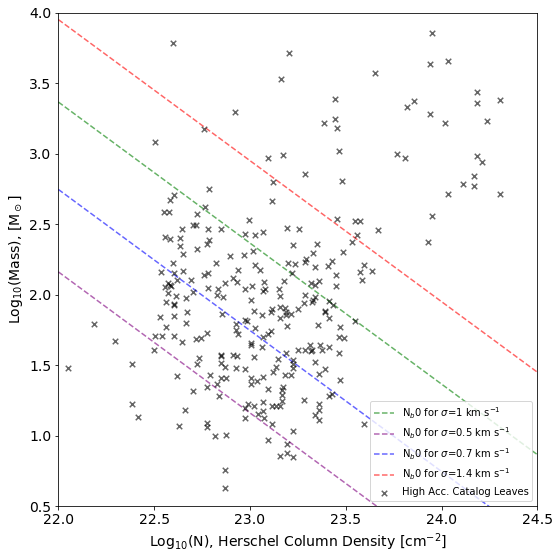

In [108]:
## side by side
plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(8,8))

ax1 = f.add_subplot(111)
ax1.scatter(np.log10(Herschel_N), np.log10(SMA_mass),s=30, color='k',
           alpha=.6,marker='x',zorder=2000,label='High Acc. Catalog Leaves')
# ax1.errorbar(x=np.log10(Herschel_N), y=np.log10(SMA_mass), ls='none',xerr=0,yerr=np.log10(noise_mass*2.0), 
#              color='k',alpha=.3,label='High Acc. Catalog Leaves')

Nvals = np.logspace(22,24.5,100)
Mvals_s1 = Mbc(nvals,1)
ax1.plot(np.log10(Nvals),np.log10(Mvals_s1),color='green', 
         alpha=0.6,ls='--',label = 'N$_b0$ for $\sigma$=1 km s$^{-1}$')
Mvals_s0p5 = Mbc(nvals,0.5)
ax1.plot(np.log10(Nvals),np.log10(Mvals_s0p5),color='purple', 
         alpha=0.6,ls='--',label = 'N$_b0$ for $\sigma$=0.5 km s$^{-1}$')
Mvals_s0p7 = Mbc(nvals,0.7)
ax1.plot(np.log10(Nvals),np.log10(Mvals_s0p7),color='blue', 
         alpha=0.6,ls='--',label = 'N$_b0$ for $\sigma$=0.7 km s$^{-1}$')
Mvals_s1p4 = Mbc(nvals,1.4)
ax1.plot(np.log10(Nvals),np.log10(Mvals_s1p4),color='red', 
         alpha=0.6,ls='--',label = 'N$_b0$ for $\sigma$=1.4 km s$^{-1}$')

legend = ax1.legend(loc='lower right', shadow=False, fontsize=10)

ax1.set_xlabel('Log$_{10}$(N), Herschel Column Density [cm$^{-2}$]')
ax1.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]')

#ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.set_xlim(22,24.5)
ax1.set_ylim(0.5,4.0)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.show()

In [113]:
region_mask = fits.open('/Users/hph/cmzoom_catalog/CMZoom_Mask_new.fits')
mask_data = region_mask[0].data

In [114]:
w = wcs.WCS(path+'CMZoom_continuum_pbcor.fits').celestial

xglon = w.wcs_world2pix(catalog['glon'],catalog['glat'],0)[0]
yglat = w.wcs_world2pix(catalog['glon'],catalog['glat'],0)[1]

In [127]:
sgrb2 = np.zeros_like(xglon)
for i in range(len(sgrb2)):
    if mask_data[int(yglat[i]),int(xglon[i])]==9:
        sgrb2[i]=1
brick = np.zeros_like(xglon)
for i in range(len(brick)):
    if mask_data[int(yglat[i]),int(xglon[i])]==16:
        brick[i]=1
nonecond = np.where(np.logical_and(np.logical_not(sgrb2), np.logical_not(brick)))
brickcond = np.where(brick)
sgrb2cond = np.where(sgrb2)

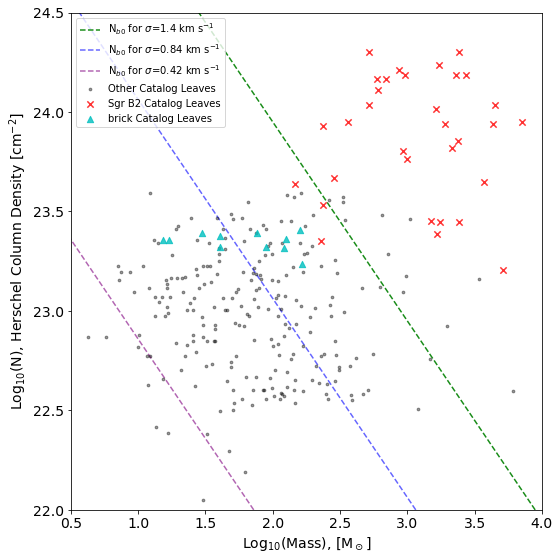

In [143]:
## side by side
plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(8,8))

ax1 = f.add_subplot(111)
ax1.scatter( np.log10(SMA_mass[nonecond]),np.log10(Herschel_N[nonecond]),s=30, color='k',
           alpha=.4,marker='.',zorder=2000,label='Other Catalog Leaves')
ax1.scatter( np.log10(SMA_mass[sgrb2cond]),np.log10(Herschel_N[sgrb2cond]),s=40, color='red',
           alpha=.8,marker='x',zorder=2000,label='Sgr B2 Catalog Leaves')
ax1.scatter( np.log10(SMA_mass[brickcond]),np.log10(Herschel_N[brickcond]),s=40, color='c',
           alpha=.8,marker='^',zorder=2000,label='brick Catalog Leaves')
# ax1.errorbar(x=np.log10(Herschel_N), y=np.log10(SMA_mass), ls='none',xerr=0,yerr=np.log10(noise_mass*2.0), 
#              color='k',alpha=.3,label='High Acc. Catalog Leaves')

Nvals = np.logspace(22,24.5,100)
Mvals_s1p4 = Mbc(nvals,1.4)
ax1.plot(np.log10(Mvals_s1p4),np.log10(Nvals),color='green', 
         alpha=0.9,ls='--',label = 'N$_{b0}$ for $\sigma$=1.4 km s$^{-1}$')
Mvals_s1 = Mbc(nvals,1)
Mvals_s0p84 = Mbc(nvals,0.84)
ax1.plot(np.log10(Mvals_s0p84),np.log10(Nvals),color='blue', 
         alpha=0.6,ls='--',label = 'N$_{b0}$ for $\sigma$=0.84 km s$^{-1}$')
Mvals_s0p42 = Mbc(nvals,0.42)
ax1.plot(np.log10(Mvals_s0p42),np.log10(Nvals),color='purple', 
         alpha=0.6,ls='--',label = 'N$_{b0}$ for $\sigma$=0.42 km s$^{-1}$')

legend = ax1.legend(loc='upper left', shadow=False, fontsize=10)

ax1.set_ylabel('Log$_{10}$(N), Herschel Column Density [cm$^{-2}$]')
ax1.set_xlabel('Log$_{10}$(Mass), [M$_\odot$]')

#ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.set_ylim(22,24.5)
ax1.set_xlim(0.5,4.0)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(path+'mass_v_density_critical.pdf')
plt.show()

In [140]:
path

'/Users/hph/cmzoom_catalog/catalog_acc/'